## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

Describe the aim of this assigment here. What are the questions you are trying to solve?

##### Packages

In [53]:
# Importing the necessary packages

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

#Setting the objects spark and sc as stated in DataCamp
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [54]:
#setting up rdd file and check if we created it correctly
fileName = "data.csv"
fileRDD = sc.textFile(fileName)
print("File path is: ", fileName)
print(fileRDD.take(5))

File path is:  data.csv
['Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class', '28395,610.291,208.1781167,173.888747,1.197191424,0.549812187,28715,190.1410973,0.763922518,0.988855999,0.958027126,0.913357755,0.007331506,0.003147289,0.834222388,0.998723889,SEKER', '28734,638.018,200.5247957,182.7344194,1.097356461,0.411785251,29172,191.2727505,0.783968133,0.984985603,0.887033637,0.953860842,0.006978659,0.003563624,0.909850506,0.998430331,SEKER', '29380,624.11,212.8261299,175.9311426,1.209712656,0.562727317,29690,193.4109041,0.778113248,0.989558774,0.947849473,0.908774239,0.007243912,0.003047733,0.825870617,0.999066137,SEKER', '30008,645.884,210.557999,182.5165157,1.153638059,0.498615976,30724,195.4670618,0.782681273,0.976695743,0.903936374,0.928328835,0.007016729,0.003214562,0.861794425,0.994198849,SEKER']


In [55]:
#creating data frame from given csv file and check it
OD = spark.read.csv(fileName, header=True, inferSchema=True)
OD.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

### Word Count (Task 1)

In [56]:
# in order not to spoil data frame we have, created a new data frame and split by "," to create an array includes eah element in the rdd
#and take a look at to the top
wordCountRDD = fileRDD.flatMap(lambda f: f.split(","))
wordCountRDD.take(20)

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4',
 'Class',
 '28395',
 '610.291',
 '208.1781167']

In [57]:
#rdd is done as key value pairs and take a look at
wordCountRDD = wordCountRDD.map(lambda f: (f,1))
wordCountRDD.take(20)

[('Area', 1),
 ('Perimeter', 1),
 ('MajorAxisLength', 1),
 ('MinorAxisLength', 1),
 ('AspectRation', 1),
 ('Eccentricity', 1),
 ('ConvexArea', 1),
 ('EquivDiameter', 1),
 ('Extent', 1),
 ('Solidity', 1),
 ('roundness', 1),
 ('Compactness', 1),
 ('ShapeFactor1', 1),
 ('ShapeFactor2', 1),
 ('ShapeFactor3', 1),
 ('ShapeFactor4', 1),
 ('Class', 1),
 ('28395', 1),
 ('610.291', 1),
 ('208.1781167', 1)]

In [58]:
#sum up the values that have the same values and sort them by using the values and take a look at
wordCountRDD = wordCountRDD.reduceByKey(lambda f,h: f+h)
wordCountRDD = wordCountRDD.sortBy(lambda f: f[1], ascending=False)
wordCountRDD.take(7)

[('DERMASON', 3546),
 ('SIRA', 2636),
 ('SEKER', 2027),
 ('HOROZ', 1928),
 ('CALI', 1630),
 ('BARBUNYA', 1322),
 ('BOMBAY', 522)]

Provide analysis and statistical information about the data set. How much data is there? What are the data types? What are the largest, smallest and average values of these data?

In [59]:
#Checking if the rdd file is created correctly and total line count
print("fileRDD type is: ", type(fileRDD))
print("Total number of lines is: ", fileRDD.count())

fileRDD type is:  <class 'pyspark.rdd.RDD'>
Total number of lines is:  13612


In [60]:
#total number of rows
print("total number of rows:", OD.count())


total number of rows: 13611


In [61]:
#Checking the column values' types
OD.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [62]:
print("Average values of each column is: ")
OD.agg({
    'Area': 'avg',
    'Perimeter': 'avg',
    'MajorAxisLength': 'avg',
    'MinorAxisLength': 'avg',
    'AspectRation': 'avg',
    'Eccentricity': 'avg',
    'ConvexArea': 'avg',
    'EquivDiameter': 'avg',
    'Extent': 'avg',
    'Solidity': 'avg',
    'roundness': 'avg',
    'Compactness':'avg',
    'ShapeFactor1':'avg',
    'ShapeFactor2':'avg',
    'ShapeFactor3':'avg',
    'ShapeFactor4':'avg'
}).show()

Average values of each column is: 
+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+--------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|   avg(roundness)|         avg(Area)|avg(EquivDiameter)|avg(MinorAxisLength)|  avg(Compactness)| avg(ShapeFactor3)|  avg(ConvexArea)|   avg(ShapeFactor2)|avg(Eccentricity)| avg(AspectRation)|   avg(Perimeter)|       avg(Extent)| avg(ShapeFactor4)|     avg(Solidity)|avg(MajorAxisLength)|   avg(ShapeFactor1)|
+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+--------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|0.873281831305413|53048.2845492616

In [63]:
print("Min values of each column is: ")
OD.agg({
    'Area': 'min',
    'Perimeter': 'min',
    'MajorAxisLength': 'min',
    'MinorAxisLength': 'min',
    'AspectRation': 'min',
    'Eccentricity': 'min',
    'ConvexArea': 'min',
    'EquivDiameter': 'min',
    'Extent': 'min',
    'Solidity': 'min',
    'roundness': 'min',
    'Compactness':'min',
    'ShapeFactor1':'min',
    'ShapeFactor2':'min',
    'ShapeFactor3':'min',
    'ShapeFactor4':'min'
}).show()

Min values of each column is: 
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|min(roundness)|min(Area)|min(EquivDiameter)|min(MinorAxisLength)|min(Compactness)|min(ShapeFactor3)|min(ConvexArea)|min(ShapeFactor2)|min(Eccentricity)|min(AspectRation)|min(Perimeter)|min(Extent)|min(ShapeFactor4)|min(Solidity)|min(MajorAxisLength)|min(ShapeFactor1)|
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|   0.489618256|    20420|       161.2437642|         122.5126535|     0.640576759|      0.410338584|          20684|       5.64169E-4|      0.218951263|      

In [64]:
print("Max values of each column is: ")
OD.agg({
    'Area': 'max',
    'Perimeter': 'max',
    'MajorAxisLength': 'max',
    'MinorAxisLength': 'max',
    'AspectRation': 'max',
    'Eccentricity': 'max',
    'ConvexArea': 'max',
    'EquivDiameter': 'max',
    'Extent': 'max',
    'Solidity': 'max',
    'roundness': 'max',
    'Compactness':'max',
    'ShapeFactor1':'max',
    'ShapeFactor2':'max',
    'ShapeFactor3':'max',
    'ShapeFactor4':'max'
}).show()

Max values of each column is: 
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|max(roundness)|max(Area)|max(EquivDiameter)|max(MinorAxisLength)|max(Compactness)|max(ShapeFactor3)|max(ConvexArea)|max(ShapeFactor2)|max(Eccentricity)|max(AspectRation)|max(Perimeter)|max(Extent)|max(ShapeFactor4)|max(Solidity)|max(MajorAxisLength)|max(ShapeFactor1)|
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|     0.9906854|   254616|       569.3743583|         460.1984968|     0.987302969|      0.974767153|         263261|      0.003664972|      0.911422968|      

In [65]:
#percentages of the ClassIndexes
print("")

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [66]:
#"Class" column has categorical string values and this makes our model cannot be trained
#we are using StringIndexer to handle this situation
#and also drop the "Class" column
#StringIndexer indexes categorical variables by their frequency so in this case:
#0: DERMASON, 1: SIRA, 2: SEKER, 3: HOROZ, 4: CALI, 5: BARBUNYA, 6: BOMBAY

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Class", outputCol="ClassIndex")
OD = indexer.fit(OD).transform(OD)
OD = OD.drop("Class")
OD.show()

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|ClassIndex|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|       2.0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.0

Explain what kind of data transformations, feature selection and/or engineering you will perform.

In [67]:
#as we can see above, some values are null so we should drop that rows all
#we googled that why are nullables true still but we found that PySpark dataframes has a bug for nullables bool values
#we can check the number of total rows and compare it to the default number of rows and we can see that data has no null values
OD = OD.na.drop(how='any')
OD.printSchema()

OD.count()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- ClassIndex: double (nullable = false)



13611

In [68]:
from pyspark.sql.types import DoubleType

#all of the columns have double values except by "Area" and "ConvexArea" so we should convert them into double too

OD = OD.withColumn("Area", OD["Area"].cast(DoubleType()))
OD = OD.withColumn("ConvexArea", OD["ConvexArea"].cast(DoubleType()))
OD.printSchema()

root
 |-- Area: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: double (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- ClassIndex: double (nullable = false)



In [69]:
from pyspark.mllib.linalg import VectorUDT
from pyspark.sql.types import FloatType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

ND = OD.select("*")

#creating normalized dataset(ND)
columns_to_normalize = ["Area", "EquivDiameter", "MinorAxisLength", "ConvexArea", "AspectRation", "Perimeter", "MajorAxisLength"]
assembler = [VectorAssembler(inputCols=[col], outputCol=col+"_Vect") for col in columns_to_normalize]
scaler = [MinMaxScaler(inputCol=col+"_Vect", outputCol=col+"_Scaled") for col in columns_to_normalize]
pipeline = Pipeline(stages=assembler + scaler)

NDModel = pipeline.fit(ND)
ND = NDModel.transform(ND)

for col in columns_to_normalize:
    ND = ND.drop(col+"_Vect")
    ND = ND.drop(col)


firstElem = F.udf(lambda v: float(v[0]), FloatType())
NDX = ND.select([firstElem(col+"_Scaled").alias(col+"_Scaled") for col in columns_to_normalize])
for col in columns_to_normalize:
#     print(col)
#     if col not in ND.schema.names:
#         firstElem(col+"_Scaled").alias(col+"_Scaled")
    NDX = NDX.withColumn(col+"_Scaled", F.col(col+"_Scaled").cast(DoubleType()))

for col in columns_to_normalize:
    ND = ND.drop(col+"_Scaled")

def append_ODs(OD1,OD2):
    list1 = OD1.columns
    list2 = OD2.columns
    for col in list2:
        if(col not in list1):
            OD1 = OD1.withColumn(col, F.lit(None))
    for col in list1:
        if(col not in list2):
            OD2 = OD2.withColumn(col, F.lit(None))
    return OD1.unionByName(OD2)

ND = append_ODs(ND,NDX)

ND.printSchema()

root
 |-- Eccentricity: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- ClassIndex: double (nullable = true)
 |-- Area_Scaled: double (nullable = true)
 |-- EquivDiameter_Scaled: double (nullable = true)
 |-- MinorAxisLength_Scaled: double (nullable = true)
 |-- ConvexArea_Scaled: double (nullable = true)
 |-- AspectRation_Scaled: double (nullable = true)
 |-- Perimeter_Scaled: double (nullable = true)
 |-- MajorAxisLength_Scaled: double (nullable = true)



## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In [70]:
from pyspark.ml.clustering import KMeans
feat_cols = []
for i in OD.schema.names:
    if i != "ClassIndex":
        feat_cols.append(i)

x = OD.select(feat_cols)
x.show(5)
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')
final_data = vec_assembler.transform(OD)

# Trains a k-means model.
kmeans = KMeans().setK(7).setSeed(1)
OD_model = kmeans.fit(final_data)

# Make predictions
OD_predictions = OD_model.transform(final_data)

# Shows the result.
centers = OD_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+-------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+
|   Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|
+-------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+
|28395.0|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|   28715.0|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|
|28734.0|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|   29172.0|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.003563624| 0.909850506

[[DenseVector([-40386.6565, 42.1247])]
 [DenseVector([-40950.2584, -38.5487])]
 [DenseVector([-41772.554, 59.0333])]
 ...
 [DenseVector([-59902.0651, 107.2769])]
 [DenseVector([-59977.5252, 44.0689])]
 [DenseVector([-59938.2662, 98.2779])]]


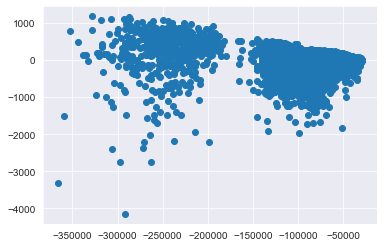

In [71]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')
x_data = vec_assembler.transform(x)

pca = PCA(k=2, inputCol='features', outputCol="pcaFeatures")
pcaModel= pca.fit(x_data)

result= pcaModel.transform(x_data).select("pcaFeatures")
pandasDf = result.toPandas()
dataX=[]
dataY=[]

print(pandasDf.values)
for vec in pandasDf.values:
    dataX.extend([vec[0][0]])
    dataY.extend([vec[0][1]])
plt.scatter(dataX,dataY)
plt.show()

In [84]:


rdd_split_int = zip(dataX,dataY)

# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(sc.parallelize(rdd_split_int), schema=["col1", "col2"]).toPandas()

# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(OD_model.clusterCenters(), columns=["col1", "col2"])

# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()

TypeError: not supported type: <class 'numpy.float64'>

Which model will be used? Why? What parameters?

## Clustering results<a class="anchor" id="clustering"></a>

Present the clustering results and graphs.

Evaluate your Clustering model. Provide results, tables, charts, etc.


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

Which model will be used? Why? What parameters?

## Evaluation<a class="anchor" id="evaluation"></a>

Evaluate your model. Provide results, tables, charts, etc.

## References<a class="anchor" id="references"></a>

List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remeber, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries will be punished badly.


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>